# 당뇨병 판정 하기

### 컬럼 정보

Pregnancies : Number of times pregnant 임신횟수

Glucose : 공복혈당 Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure : Diastolic blood pressure (mm Hg)

SkinThickness : Triceps skin fold thickness (mm)

Insulin : 2-Hour serum insulin (mu U/ml)

BMI : Body mass index (weight in kg/(height in m)^2)

Diabetes pedigree function

Age (years)

COutcome : class variable (0 or 1) 268 of 768 are 1, the others are 0



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
%matplotlib inline


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
from lightgbm import LGBMClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/K-digital/WorkFlow')

In [4]:
data = './diabetes.csv'

In [5]:
df = pd.read_csv(data)

In [7]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.isna().sum()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


<Figure size 360x360 with 0 Axes>

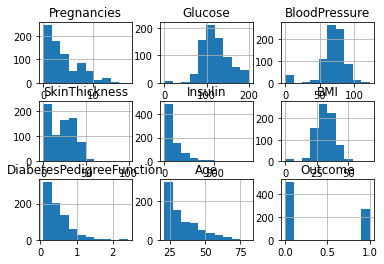

In [21]:
plt.figure(figsize = (5,5))
df.hist()
plt.show()

NaN 데이터는 없으나

혈압, 피부의 두께등에서 0의 자료가 검출된다.

NaN대신 0으로 자료를 처리하였음을 유추할 수 있다.

# Feature Engineering

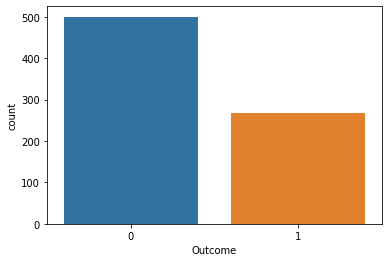

In [24]:
sns.countplot(data=df, x='Outcome')
plt.show()

### X, y 분리

In [29]:
X = df.iloc[:, :-1]

In [30]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [43]:
y = df['Outcome']

### 각 컬럼에 0으로 채워진 데이터 처리

몇몇 컬럼은 0이 NaN의 의미를 갖는다.

NaN은 보다 쉽게 데이터를 처리할 수 있지만, 0은 그렇지 못하므로

해당 컬럼의 0 값들은 NaN으로 한번 바꿔주는 편이 더 쉽고 빠르게 데이터를 가공할 수 있을 것이다.

+ 나아가서 직접 데이터를 구성할 때도 없는 데이터는 null이나 NaN같은 데이터 없음 상태를 유지해야지, 0이나 'X', '데이터 없음' 같은 형식으로 구성하는 것은 작업 소요를 늘린다는 것을 알 수 있다.

In [31]:
from sklearn.impute import SimpleImputer # 없는 값을 바꿔주는 함수. 매뉴얼 찾아보기.

In [32]:
si = SimpleImputer(missing_values=0)

In [33]:
X.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32


In [34]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [36]:
X_si = si.fit_transform(X[['Glucose','BloodPressure','SkinThickness','BMI']]) # array

In [37]:
X[['Glucose','BloodPressure','SkinThickness','BMI']] = X_si

In [41]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,79.799479,32.457464,0.471876,33.240885
std,3.369578,30.435949,12.096346,8.790942,115.244002,6.875151,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,0.000000,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.202592,29.153420,30.500000,32.400000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### X, y 분리하고, 트레이닝 테스스트 셋 처리

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [46]:
X_train.shape

(614, 8)

In [47]:
y_train.shape

(614,)

# Model Building and Evaluation

In [68]:
import joblib
def FitModel(X_train,y_train,X_test,y_test,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)

    grid = GridSearchCV(algorithm, gridSearchParams, scoring = 'accuracy', n_jobs = -1, cv = cv, verbose=1)
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_model = grid_result.best_estimator_

    joblib.dump (best_model, 'best_model.pkl')

    y_pred = grid_result.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    print('y_pred : ', y_pred)
    print('Best Params : ', best_params)
    print('Accuracy Score : ', accuracy_score(y_test, y_pred))
    print('Confusion Matrix : \n', cm)


    

# XgBoost

강의 노트 : https://docs.google.com/presentation/d/1pvgye0Gt5DKgA7Kn5pc4Cfy-D4VtmQTxVIvbxa-GfFc/edit#slide=id.gbebab87311_2_30

In [69]:
param = {'n_estimators' : [100,500], 'max_depth' : [3,4,5], 'learning_rate': [0.01, 0.1]} #이 수치는 필요에 따라 조정 가능.

In [70]:
FitModel (X_train, y_train, X_test, y_test, 'XGBOOST', XGBClassifier(), param, 10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
y_pred :  [1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy Score :  0.7207792207792207
Confusion Matrix : 
 [[79 16]
 [27 32]]


피쳐 스케일링

In [71]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
scaler_X = MinMaxScaler()

In [73]:
X_train = scaler_X.fit_transform(X_train)

In [74]:
X_test = scaler_X.transform(X_test) # 형식이 같고, 데이터의 수는 많은 X_train으로 학습을 했기 때문에 X_test는 transform만 한다.

In [75]:
FitModel (X_train, y_train, X_test, y_test, 'XGBOOST', XGBClassifier(), param, 10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
y_pred :  [1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy Score :  0.7207792207792207
Confusion Matrix : 
 [[79 16]
 [27 32]]


점수가 완전히 동일하게 나왔으므로 피쳐 스케일링에 의미가 없었고
XGBoost는 자체적으로 피쳐 스케일링을 거친다고 미루어 볼 수 있다.

# Random Forest

In [76]:
param = {'n_estimators' : [100,200,500,1000,1500]}

In [77]:
FitModel (X_train, y_train, X_test, y_test, 'Random Forest', RandomForestClassifier(), param, 10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
y_pred :  [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0
 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 0 0]
Best Params :  {'n_estimators': 200}
Accuracy Score :  0.7337662337662337
Confusion Matrix : 
 [[83 12]
 [29 30]]


# SVC

In [78]:
param = {'C' : [0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.1, 0.005, 1]}

In [79]:
FitModel (X_train, y_train, X_test, y_test, 'SVC', SVC(), param, 10)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
y_pred :  [1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1
 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 0 1 0]
Best Params :  {'C': 10, 'gamma': 0.1}
Accuracy Score :  0.7337662337662337
Confusion Matrix : 
 [[85 10]
 [31 28]]


데이터간의 불균형이 있을 때 (예컨데, 당장은 outcome이 1인 데이터와 0인 데이터)

불균형이 클 수록 학습이 제대로 이루어지지 않는다. (극단적으로 10000 : 1의 자료비에서 학습이 안되는것과 같은 이치이다.)

따라서 더 많은 쪽을, 저 적은쪽에 가깝게 맞추거나 (다운 샘플링)

더 적은 쪽을 더 많은 쪽에 맞춰서 (오버 샘플링)

자료의 양을 맞춘다.

오버 샘플링은 임의의 데이터를 삽입하는 만큼, 불안요소가 늘어나는 셈이다.

따라서 자료의 양이 충분하다거나 민감한 자료를 사용한다면 다운 샘플링도 정답이 될 수 있다.

# Balancing the Dataset - Over Sampling

In [80]:
from imblearn.over_sampling import SMOTE #SMOTE가 오버샘플링할 수 있는 유일한 방법은 아님.

In [81]:
sm = SMOTE(random_state=10)

In [83]:
X_res, y_res = sm.fit_resample(X,y)

In [84]:
X_res.shape

(1000, 8)

In [85]:
X.shape

(768, 8)

# XgBoost  - After Over sampling

In [94]:
scaler_X = MinMaxScaler()

In [95]:
X_res = scaler_X.fit_transform(X_res)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=10)

In [99]:
param = {'n_estimators' : [100,500], 'max_depth' : [3,4,5], 'learning_rate': [0.01, 0.1]} #이 수치는 필요에 따라 조정 가능.

In [100]:
FitModel (X_train, y_train, X_test, y_test, 'XGBOOST', XGBClassifier(), param, 10)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
y_pred :  [0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0
 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0
 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0]
Best Params :  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Accuracy Score :  0.805
Confusion Matrix : 
 [[71 22]
 [17 90]]


# Random Forest  - After Over sampling

In [105]:
param = {'n_estimators' : [100,200,500,1000,1500]}

In [106]:
FitModel (X_train, y_train, X_test, y_test, 'Random Forest', RandomForestClassifier(), param, 10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
y_pred :  [1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0]
Best Params :  {'n_estimators': 1500}
Accuracy Score :  0.81
Confusion Matrix : 
 [[71 22]
 [16 91]]


In [107]:
joblib.dump(scaler_X, 'scaler_X.pkl')

['scaler_X.pkl']

# SVC  - After Over sampling

In [103]:
param = {'C' : [0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.1, 0.005, 1]}

In [104]:
FitModel (X_train, y_train, X_test, y_test, 'SVC', SVC(), param, 10)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
y_pred :  [0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1
 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0
 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1
 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0]
Best Params :  {'C': 10, 'gamma': 1}
Accuracy Score :  0.765
Confusion Matrix : 
 [[69 24]
 [23 84]]
